# Flow past a cylinder (DFG 2D-3 benchmark)
This notebook implements the solution of the flow over cylinder based on the implementation by J. Dokken on the [FEniCSx tutorials](https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code2.html) and the [IPCS solver for Navier-Stokes](https://github.com/jorgensd/dolfinx_ipcs).

The kinematic velocity is given by $\nu=\frac{\mu}{\rho}=0.001\,\frac{m^2}{s}$ and the inflow velocity profile is specified as (with $\mathbf{x}=[x,y]^T$)
\begin{equation*}
\begin{split}
\mathbf{u}_{in}(\mathbf{x},t) &= \left[ U \cdot \frac{4\,y(0.41-y)}{0.41^2}, 0 \right]^T\\
U=U(t) &= 1.5\sin(\pi t/8)
\end{split}
\end{equation*}
which has a maximum magnitude of $1.5$ at $y=0.41/2$. 

In [2]:
import gmsh
import os
from IPython.display import clear_output
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.io import gmshio, XDMFFile

from pyforce.tools.backends import LoopProgress

## Mesh generation
The geometry and the domain will be defined using *gmsh* in Python.

In [3]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh_factor = .5

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cyl_dfg2D.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

clear_output()

# Import into dolfinx
model_rank = 0
mesh, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )

ft.name = "Facet markers"

bound_markers = dict()
bound_markers['inlet']     = 1
bound_markers['walls']     = 2
bound_markers['outlet']    = 3
bound_markers['obstacle']  = 4

domain_marker = 10

mesh.topology.create_connectivity(gdim, gdim)
mesh.topology.create_connectivity(gdim-1, gdim)

# Finalize the gmsh module
gmsh.finalize()

## Physical and discretization parameters
Following the DGF-2 benchmark, we define our problem specific parameters

In [4]:
t = 0
T = 8                       # Final time
dt = 5.00e-4                # Time step size
num_steps = int(T/dt)

params = dict()
params['nu'] = 1e-3
params['dt'] = dt
params['T']  = T

# Define boundary conditions
class InletVelocity():
    def __init__(self, t, T):
        self.t = t
        self.T = 8

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (0.41 - x[1])/(0.41**2) * 1.5 * np.sin(self.t * np.pi/self.T)
        return values
    
print('The Reynolds number is {:.2f}'.format(1 * 0.1 / params['nu']))

The Reynolds number is 100.00


## Assembling variational forms

The Navier-Stokes equations are discretised using a fractional step method: at first, a tentative velocity is computed and then the incompressibility constraint is enforced through the solution the pressure Poisson problem.

Three different options have been implemented for the time discretisation of the tentative velocity problem: 

1. *BDF2* = Backward Differentiation Formula of order 2
2. *CN* = Crank-Nicolson
3. *EI* = Euler Implitict

In [4]:
from ns import *
time_adv = 'BDF2'

step01 = tentative_velocity(mesh, ct, ft, InletVelocity, params, bound_markers, time_adv=time_adv)
step01.assembleForm(direct=False)

step02 = pressure_projection(mesh, ct, ft, params, bound_markers, time_adv=time_adv)
step02.assembleForm(direct=False)

step03 = update_velocity(mesh, ct, ft, params, time_adv=time_adv)
step03.assembleForm(direct=False)

### Setting up the tools to compute drag and lift coefficient
The FOM will be validation against the FEATFLOW dataset comparing the drag $c_D$ and lift $c_L$ coefficients, defined as

\begin{equation*}
\begin{split}
c_{\text{D}} &= \frac{2}{\rho L U_{mean}^2}\int_{\Gamma_S} \nu \frac{\partial u_{t_S}}{\partial \mathbf{n}}n_y -p n_x~\mathrm{d} s\\
c_{\text{L}} &= -\frac{2}{\rho L U_{mean}^2}\int_{\Gamma_S} \nu \frac{\partial u_{t_S}}{\partial \mathbf{n}}n_x + p n_y~\mathrm{d} s
\end{split}
\end{equation*}
where $u_{t_S}$ is the tangential velocity component at the interface of the obstacle $\partial\Omega_S$, defined as $u_{t_S}=u\cdot (n_y,-n_x)$, $U_{mean}=1$ the average inflow velocity, and $L$ the length of the channel. We use `UFL` to create the relevant integrals, and assemble them at each time step.

In [5]:
params['rhoLU2'] = 0.1
get_drag_lift = drag_lift(mesh, ft, params, bound_markers['obstacle'])

## Solving the time-dependent problem
The velocity and the pressure are stored to be later saved in appropriate data structures.

In [6]:
progr_bar = LoopProgress('Solving NS', final = T)

store_snap = False
    
if store_snap:
    u_xdmf = XDMFFile(mesh.comm, "Snapshots/snaps_u.xdmf", "w")
    p_xdmf = XDMFFile(mesh.comm, "Snapshots/snaps_p.xdmf", "w")

    u_xdmf.write_mesh(mesh)
    p_xdmf.write_mesh(mesh)

LL = 100
kk = 1
time_store = list()

for i in range(num_steps):
    
    # Update current time step
    t += dt
    
    # Tentative velocity
    step01.advance(t)
    
    # Pressure projection
    step02.advance(step01.u_tilde)
    
    if time_adv != 'EI':
        with step01.uOld.vector.localForm() as loc_, step01.u_n.vector.localForm() as loc_n:
            loc_.copy(loc_n)
        
    step03.advance(step01.u_tilde, step02.phi)
    
    step01.pOld.vector.axpy(1, step02.phi.vector)
    step01.pOld.x.scatter_forward()
    
    # Save solution
    if (np.isclose(t, kk * LL * dt)):
        if store_snap:
            u_xdmf.write_function(step03.u_new, t)
            p_xdmf.write_function(step01.pOld, t)
        
        # Compute QoI
        get_drag_lift.compute(t, dt, step03.u_new, step01.pOld)
        
        kk += 1

    # Update old
    with step03.u_new.vector.localForm() as loc_, step01.uOld.vector.localForm() as loc_n:
        loc_.copy(loc_n)
        
        
    progr_bar.update(dt, percentage=False)
        
if store_snap:
    u_xdmf.close()
    p_xdmf.close()

Store QoI data

In [ ]:
import pickle

res = dict()
res['t_u'] = get_drag_lift.t_u
res['t_p'] = get_drag_lift.t_p
res['C_D'] = get_drag_lift.C_D
res['C_L'] = get_drag_lift.C_L
res['dP']  = get_drag_lift.p_diff

pickle.dump(res, open('./../BenchmarkData/QoI_'+time_adv, 'wb'))

### Comparison with benchmark data
The drag and lift coefficients are compared with benchmark data from [DFG2](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).

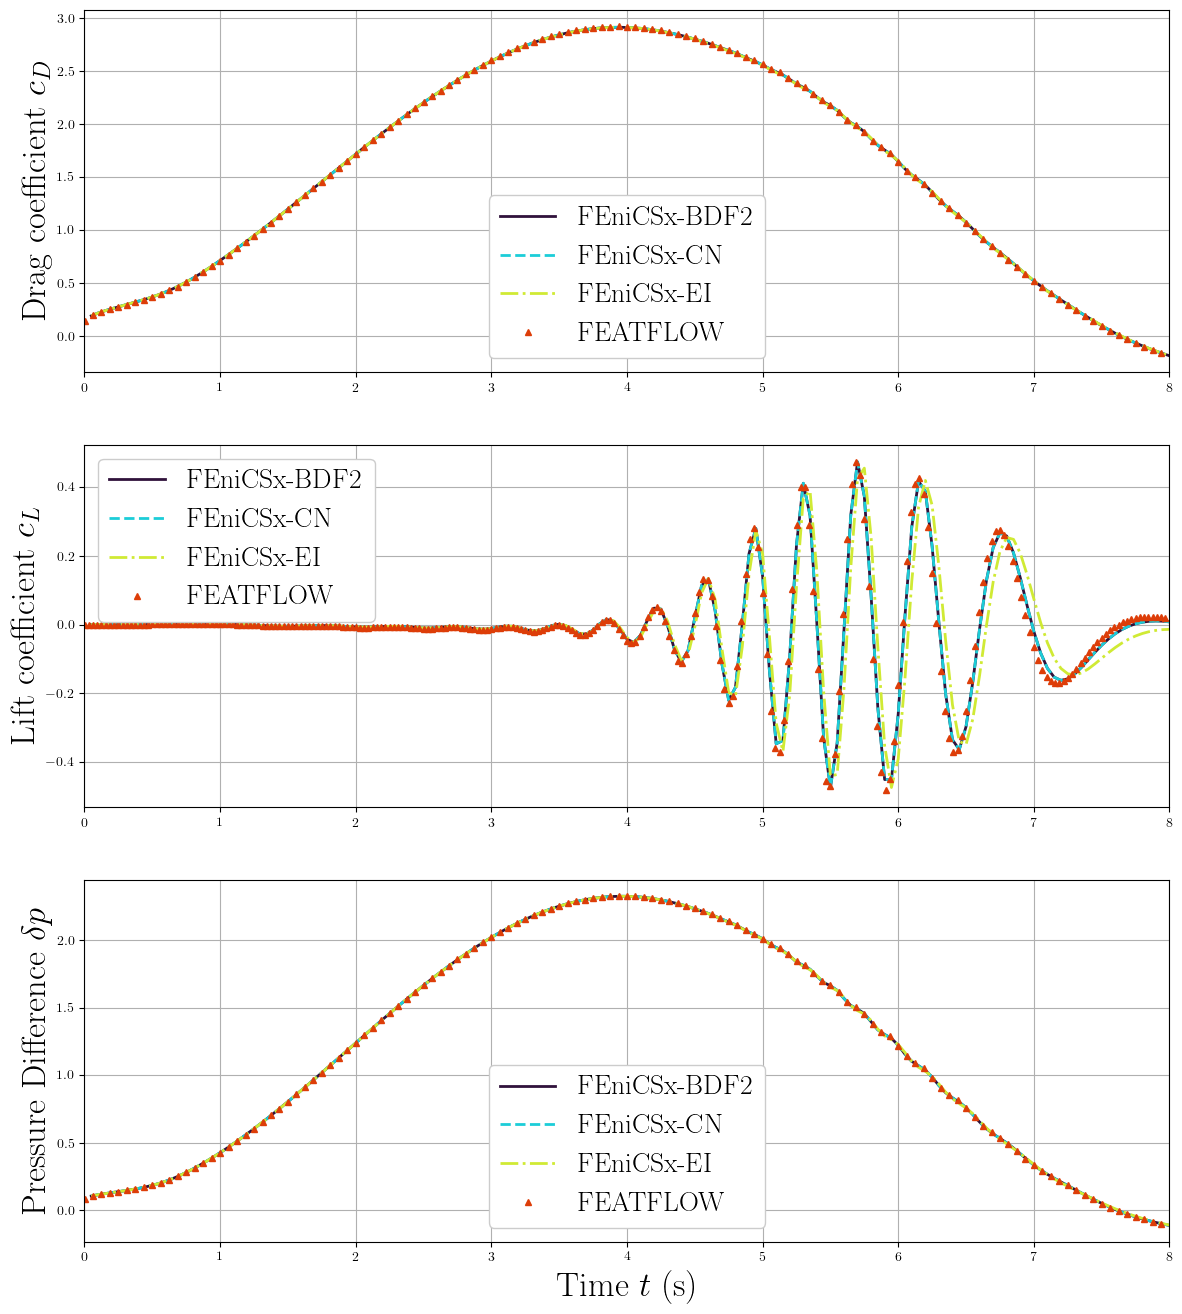

In [ ]:
turek = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/bdforces_lv4.txt")
turek_p = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/pointvalues_lv4.txt")

# time_adv_schemes = ['BDF2', 'CN', 'EI']
time_adv_schemes = ['BDF2']
QoI_data = [pickle.load(open('./../BenchmarkData/QoI_'+time_adv_schemes[kk], 'rb')) for kk in range(len(time_adv_schemes))]
colors = cm.turbo(np.linspace(0., 0.85, len(time_adv_schemes)+1))
line_styles = ['-', '--', '-.']


fig = plt.figure(figsize=(14,16))

plt.subplot(3,1,1)

for kk in range(len(time_adv_schemes)):
    plt.plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_D'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
plt.plot(turek[1:,1], turek[1:,3], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
plt.ylabel(r"Drag coefficient $c_D$", fontsize=25)
plt.grid()
plt.xlim(0,T)
plt.legend(framealpha=1, fontsize=20)

plt.subplot(3,1,2)
for kk in range(len(time_adv_schemes)):
    plt.plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_L'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
plt.plot(turek[1:,1], turek[1:,4], "^", color=colors[-1], markevery=50, markersize=5, label="FEATFLOW")
plt.ylabel(r"Lift coefficient $c_L$", fontsize=25)
plt.grid()
plt.xlim(0,T)
plt.legend(framealpha=1, fontsize=20)

plt.subplot(3,1,3)
for kk in range(len(time_adv_schemes)):
    plt.plot(QoI_data[kk]['t_p'], QoI_data[kk]['dP'], color=colors[kk], linestyle=line_styles[kk], label=r"FEniCSx-"+time_adv_schemes[kk], linewidth=2)
plt.plot(turek[1:,1], turek_p[1:,6]-turek_p[1:,-1], "^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
plt.ylabel(r"Pressure Difference $\delta p$", fontsize=25)
plt.xlabel(r"Time $t$ (s)", fontsize=25)
plt.grid()
plt.xlim(0,T)
plt.legend(framealpha=1, fontsize=20)

fig.savefig('./../BenchmarkData/LaminarNS_DFG2/FOM_bench_comparison.pdf', format='pdf', dpi=300, bbox_inches='tight')